In [2]:
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.util import ngrams as nltk_ngrams  # Explicit import to avoid conflicts
from collections import Counter
import gensim.downloader as api
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [3]:
# Download required NLTK data
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nimis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

In [5]:
# Load the data
true_csv_path = r"C:\Users\nimis\OneDrive\Documents\Semantic Assignment\Starter+Notebook+++Data\Starter Notebook + Data\True.csv"
fake_csv_path = r"C:\Users\nimis\OneDrive\Documents\Semantic Assignment\Starter+Notebook+++Data\Starter Notebook + Data\Fake.csv"
true_df = pd.read_csv(true_csv_path)
fake_df = pd.read_csv(fake_csv_path)

In [6]:
# 1. Data Preparation
print("True News DataFrame Info:")
print(true_df.info())
print("\nFake News DataFrame Info:")
print(fake_df.info())
print("\nTrue News Columns:", true_df.columns.tolist())
print("Fake News Columns:", fake_df.columns.tolist())

True News DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   21417 non-null  object
 1   text    21417 non-null  object
 2   date    21417 non-null  object
dtypes: object(3)
memory usage: 502.1+ KB
None

Fake News DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23523 entries, 0 to 23522
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   23502 non-null  object
 1   text    23502 non-null  object
 2   date    23481 non-null  object
dtypes: object(3)
memory usage: 551.4+ KB
None

True News Columns: ['title', 'text', 'date']
Fake News Columns: ['title', 'text', 'date']


In [7]:
# Add new column
true_df['news_label'] = 1
fake_df['news_label'] = 0

In [8]:
# Merge DataFrames
combined_df = pd.concat([true_df, fake_df], ignore_index=True)
print("\nCombined DataFrame First 5 Rows:")
print(combined_df.head())


Combined DataFrame First 5 Rows:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text                date  \
0  WASHINGTON (Reuters) - The head of a conservat...  December 31, 2017    
1  WASHINGTON (Reuters) - Transgender people will...  December 29, 2017    
2  WASHINGTON (Reuters) - The special counsel inv...  December 31, 2017    
3  WASHINGTON (Reuters) - Trump campaign adviser ...  December 30, 2017    
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  December 29, 2017    

   news_label  
0           1  
1           1  
2           1  
3           1  
4           1  


In [9]:
# Handle null values
print("\nNull Values in Combined DataFrame:")
print(combined_df.isnull().sum())
combined_df = combined_df.dropna(subset=['text', 'title'])
print("\nNull Values After Handling:")
print(combined_df.isnull().sum())


Null Values in Combined DataFrame:
title         21
text          21
date          42
news_label     0
dtype: int64

Null Values After Handling:
title          0
text           0
date          21
news_label     0
dtype: int64


In [10]:
# Merge relevant columns
combined_df['news_text'] = combined_df['title'] + " " + combined_df['text']
combined_df = combined_df.drop(['title', 'text', 'date'], axis=1)
print("\nUpdated DataFrame First 5 Rows:")
print(combined_df.head())


Updated DataFrame First 5 Rows:
   news_label                                          news_text
0           1  As U.S. budget fight looms, Republicans flip t...
1           1  U.S. military to accept transgender recruits o...
2           1  Senior U.S. Republican senator: 'Let Mr. Muell...
3           1  FBI Russia probe helped by Australian diplomat...
4           1  Trump wants Postal Service to charge 'much mor...


In [11]:
# Check for outliers (texts < 10 characters)
combined_df['text_length'] = combined_df['news_text'].apply(len)
outliers = combined_df[combined_df['text_length'] < 10]
print("\nOutliers (texts < 10 characters):", len(outliers))
combined_df = combined_df[combined_df['text_length'] >= 10].drop('text_length', axis=1)


Outliers (texts < 10 characters): 0


In [12]:
# 2. Text Preprocessing
df_clean = pd.DataFrame()
df_clean['news_label'] = combined_df['news_label']
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df_clean['cleaned_text'] = combined_df['news_text'].progress_apply(clean_text)
df_clean['cleaned_text'] = df_clean['cleaned_text'].fillna("")

100%|██████████████████████████████████████████████████████████████████████████| 44919/44919 [00:11<00:00, 3747.09it/s]


In [13]:
# Batch POS tagging and lemmatization
def pos_lemmatize_batch(texts):
    results = []
    for doc in nlp.pipe(texts, disable=["parser", "ner"]):
        tokens = [token.lemma_ for token in doc if token.pos_ == 'NOUN' and token.text not in stop_words]
        results.append(' '.join(tokens))
    return results

chunk_size = 1000
texts = df_clean['cleaned_text'].tolist()
lemmatized_texts = []
for i in tqdm(range(0, len(texts), chunk_size), desc="Lemmatizing texts"):
    chunk = texts[i:i+chunk_size]
    lemmatized_texts.extend(pos_lemmatize_batch(chunk))
df_clean['lemmatized_text'] = lemmatized_texts
df_clean['lemmatized_text'] = df_clean['lemmatized_text'].fillna("")

Lemmatizing texts: 100%|███████████████████████████████████████████████████████████████| 45/45 [07:36<00:00, 10.15s/it]


In [14]:
# Save cleaned data
df_clean.to_csv("clean_df.csv", index=False)

In [15]:
# 3. Train Validation Split
train_df, val_df = train_test_split(df_clean, test_size=0.3, random_state=42, stratify=df_clean['news_label'])

In [16]:
# 4. Exploratory Data Analysis on Training Data
# Character length visualization (saves char_length_histogram.png)
train_df['cleaned_length'] = train_df['cleaned_text'].apply(len)
train_df['lemmatized_length'] = train_df['lemmatized_text'].apply(len)

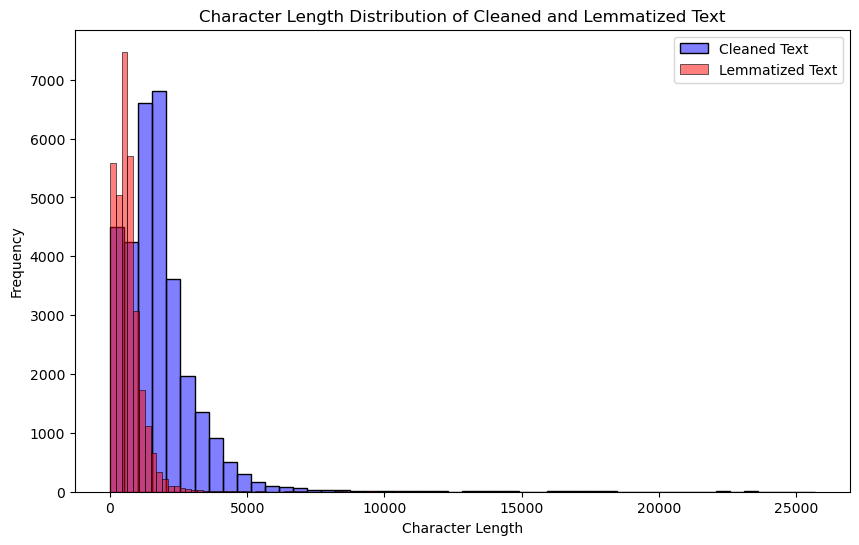

In [17]:
# Optional: EDA on Validation Data
# Character length distribution for validation data
plt.figure(figsize=(10, 6))
sns.histplot(train_df['cleaned_length'], bins=50, color='blue', alpha=0.5, label='Cleaned Text')
sns.histplot(train_df['lemmatized_length'], bins=50, color='red', alpha=0.5, label='Lemmatized Text')
plt.title('Character Length Distribution of Cleaned and Lemmatized Text')
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('char_length_histogram.png')
plt.show()
plt.close()

In [18]:
# Top 40 words with table output
def get_top_words(text_series, top_k=40):
    text = ' '.join(text_series.dropna().astype(str))
    words = text.split()
    return Counter(words).most_common(top_k)

true_words = get_top_words(train_df[train_df['news_label'] == 1]['lemmatized_text'])
fake_words = get_top_words(train_df[train_df['news_label'] == 0]['lemmatized_text'])
print("\nTop 40 Words in True News:")
print(pd.DataFrame(true_words, columns=['Word', 'Frequency']))
print("\nTop 40 Words in Fake News:")
print(pd.DataFrame(fake_words, columns=['Word', 'Frequency']))


Top 40 Words in True News:
              Word  Frequency
0            trump      19597
1             year      13199
2       government      13191
3            state      12502
4           people      10492
5         election       9404
6          country       8919
7         official       8237
8         campaign       7436
9             week       7403
10           group       7202
11          leader       7097
12         percent       6777
13           month       6172
14             law       6142
15        security       6003
16           party       5858
17            time       5750
18       statement       5716
19             tax       5713
20       president       5685
21            vote       5670
22          policy       5341
23             day       5080
24           court       4803
25  administration       4694
26            plan       4689
27            bill       4455
28           force       4376
29            deal       4254
30           issue       4235
31          

In [19]:
# N-gram analysis with reusable plotting
def get_top_ngrams(text_series, n, top_k=10):
    text_series = text_series.dropna().astype(str)
    all_ngrams = []
    for text in text_series:
        tokens = text.split()
        if tokens:
            ngram_list = list(nltk_ngrams(tokens, n))
            all_ngrams.extend(['_'.join(ngram) for ngram in ngram_list])
    return Counter(all_ngrams).most_common(top_k)

def plot_ngrams(ngrams, title, filename):
    if not ngrams:
        print(f"No {title} found.")
        return
    terms, counts = zip(*ngrams)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(terms))
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('N-gram')
    plt.savefig(filename)
    plt.show()
    plt.close()


Top 10 Unigrams in True News: [('trump', 19597), ('year', 13199), ('government', 13191), ('state', 12502), ('people', 10492), ('election', 9404), ('country', 8919), ('official', 8237), ('campaign', 7436), ('week', 7403)]


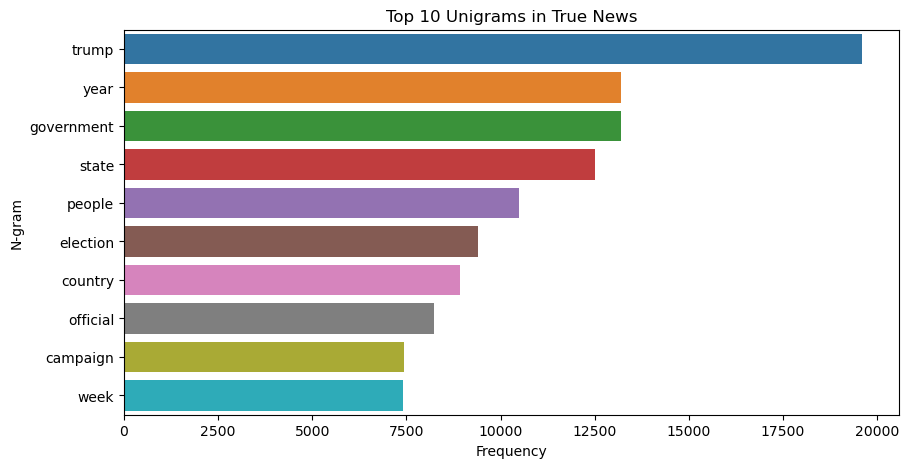


Top 10 Bigrams in True News: [('trump_campaign', 874), ('percent_percent', 844), ('security_force', 707), ('request_comment', 705), ('climate_change', 697), ('tax_reform', 676), ('intelligence_agency', 584), ('right_group', 573), ('news_conference', 545), ('tax_cut', 542)]


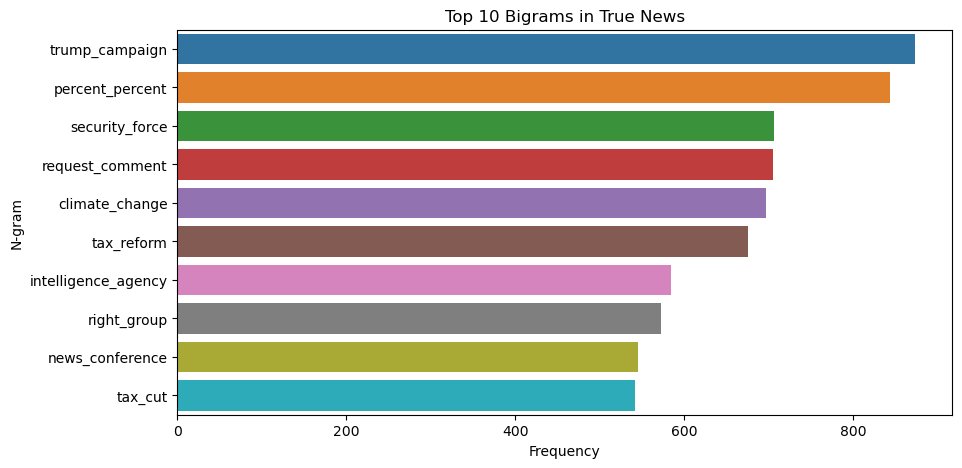


Top 10 Trigrams in True News: [('official_condition_anonymity', 179), ('reuter_editorial_staff', 165), ('tax_rate_percent', 164), ('respond_request_comment', 164), ('percent_percent_percent', 143), ('part_reuter_editorial', 122), ('editorial_staff_sap', 122), ('staff_sap_involvement', 122), ('sap_involvement_creation', 122), ('involvement_creation_production', 122)]


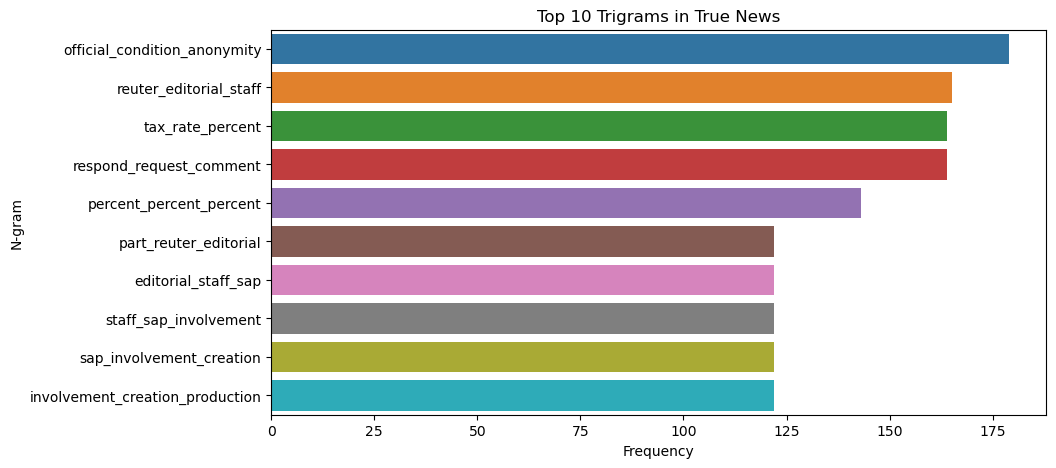

In [20]:
# True News N-grams (saves true_unigrams.png, true_bigrams.png, true_trigrams.png)
for n, name in [(1, 'Unigrams'), (2, 'Bigrams'), (3, 'Trigrams')]:
    ngrams = get_top_ngrams(train_df[train_df['news_label'] == 1]['lemmatized_text'], n)
    print(f"\nTop 10 {name} in True News:", ngrams)
    plot_ngrams(ngrams, f'Top 10 {name} in True News', f'true_{name.lower()}.png')


Top 10 Unigrams in Fake News: [('trump', 35274), ('people', 18107), ('time', 10684), ('year', 10487), ('image', 9665), ('state', 8237), ('president', 8078), ('woman', 8027), ('video', 7743), ('medium', 7465)]


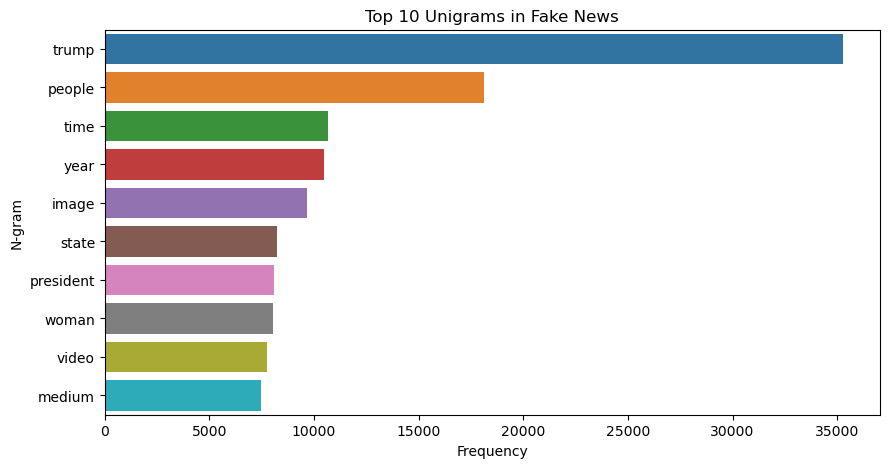


Top 10 Bigrams in Fake News: [('trump_supporter', 1408), ('trump_campaign', 1286), ('image_image', 1258), ('police_officer', 1165), ('law_enforcement', 1065), ('century_wire', 943), ('screen_capture', 929), ('donald_trump', 924), ('mainstream_medium', 818), ('trump_realdonaldtrump', 773)]


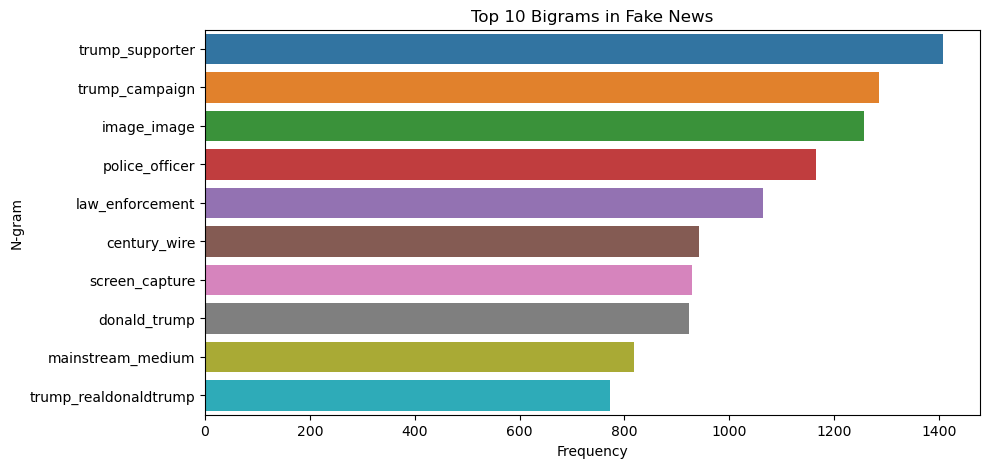


Top 10 Trigrams in Fake News: [('video_screen_capture', 520), ('image_video_screen', 477), ('news_century_wire', 361), ('image_getty_image', 314), ('image_screen_capture', 303), ('image_chip_image', 179), ('image_video_screenshot', 162), ('law_enforcement_officer', 153), ('broadcast_boiler_room', 148), ('talk_radio_custommade', 143)]


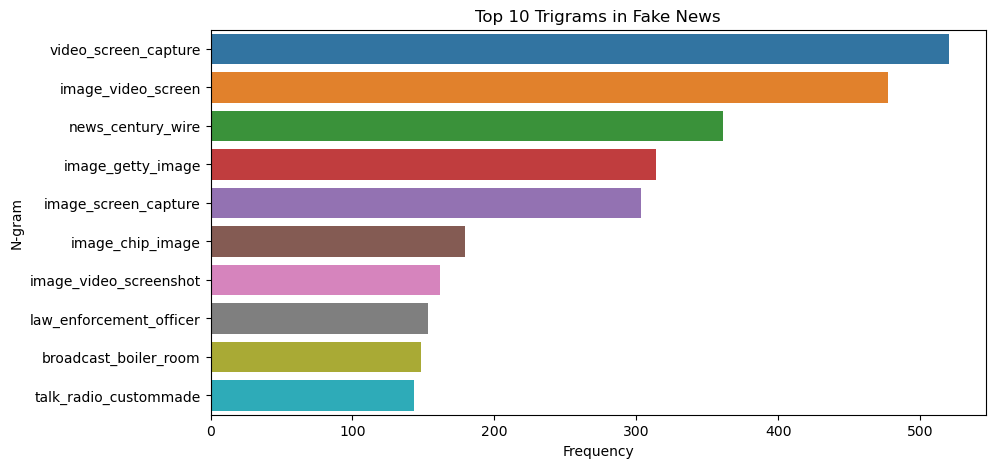

In [21]:
# Fake News N-grams (saves fake_unigrams.png, fake_bigrams.png, fake_trigrams.png)
for n, name in [(1, 'Unigrams'), (2, 'Bigrams'), (3, 'Trigrams')]:
    ngrams = get_top_ngrams(train_df[train_df['news_label'] == 0]['lemmatized_text'], n)
    print(f"\nTop 10 {name} in Fake News:", ngrams)
    plot_ngrams(ngrams, f'Top 10 {name} in Fake News', f'fake_{name.lower()}.png')

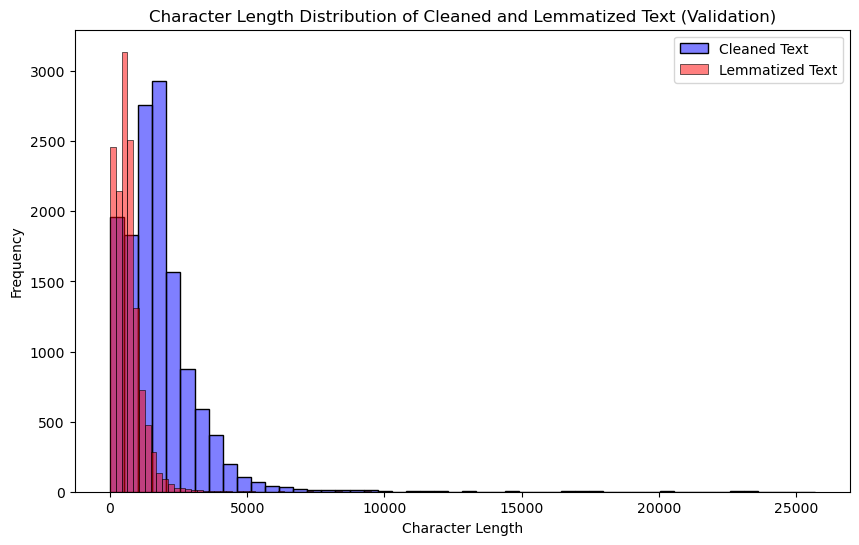

In [22]:
# 5. Exploratory Data Analysis on Validation Data (Optional)
# Character length visualization (saves val_char_length_histogram.png)
val_df['cleaned_length'] = val_df['cleaned_text'].apply(len)
val_df['lemmatized_length'] = val_df['lemmatized_text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(val_df['cleaned_length'], bins=50, color='blue', alpha=0.5, label='Cleaned Text')
sns.histplot(val_df['lemmatized_length'], bins=50, color='red', alpha=0.5, label='Lemmatized Text')
plt.title('Character Length Distribution of Cleaned and Lemmatized Text (Validation)')
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('val_char_length_histogram.png')
plt.show()
plt.close()

In [23]:
# Top 40 words for validation data
val_true_words = get_top_words(val_df[val_df['news_label'] == 1]['lemmatized_text'])
val_fake_words = get_top_words(val_df[val_df['news_label'] == 0]['lemmatized_text'])
print("\nTop 40 Words in True News (Validation):")
print(pd.DataFrame(val_true_words, columns=['Word', 'Frequency']))
print("\nTop 40 Words in Fake News (Validation):")
print(pd.DataFrame(val_fake_words, columns=['Word', 'Frequency']))


Top 40 Words in True News (Validation):
              Word  Frequency
0            trump       8179
1             year       5626
2       government       5531
3            state       5306
4           people       4369
5         election       4111
6          country       3843
7         official       3507
8           leader       3134
9             week       3097
10        campaign       3045
11         percent       3001
12           group       2936
13           month       2599
14           party       2592
15       statement       2539
16        security       2528
17             law       2485
18       president       2482
19            vote       2425
20            time       2418
21             tax       2396
22          policy       2214
23             day       2078
24            plan       2000
25  administration       1967
26           court       1926
27            bill       1850
28           force       1849
29         company       1789
30         comment       1785


Top 10 Unigrams in True News (Validation): [('trump', 8179), ('year', 5626), ('government', 5531), ('state', 5306), ('people', 4369), ('election', 4111), ('country', 3843), ('official', 3507), ('leader', 3134), ('week', 3097)]


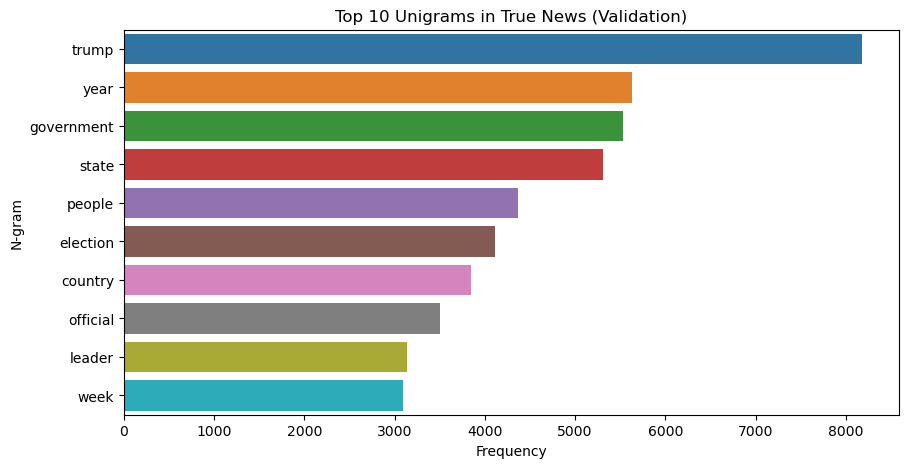


Top 10 Unigrams in Fake News (Validation): [('trump', 14217), ('people', 7647), ('time', 4491), ('year', 4396), ('image', 4090), ('state', 3559), ('president', 3335), ('campaign', 3203), ('video', 3190), ('woman', 3133)]


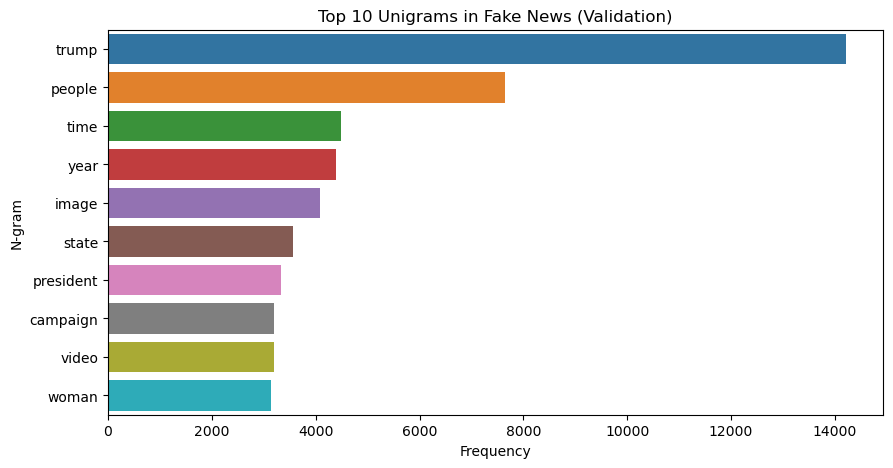


Top 10 Bigrams in True News (Validation): [('percent_percent', 375), ('trump_campaign', 332), ('request_comment', 313), ('tax_reform', 306), ('climate_change', 299), ('security_force', 271), ('intelligence_agency', 263), ('news_conference', 241), ('right_group', 239), ('election_campaign', 221)]


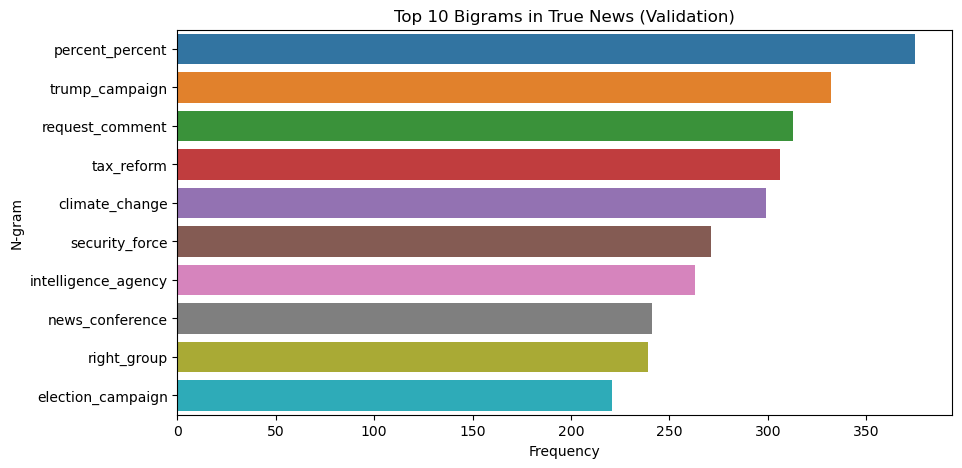


Top 10 Bigrams in Fake News (Validation): [('trump_supporter', 610), ('image_image', 581), ('trump_campaign', 566), ('police_officer', 504), ('century_wire', 444), ('law_enforcement', 433), ('screen_capture', 398), ('donald_trump', 364), ('president_trump', 321), ('mainstream_medium', 311)]


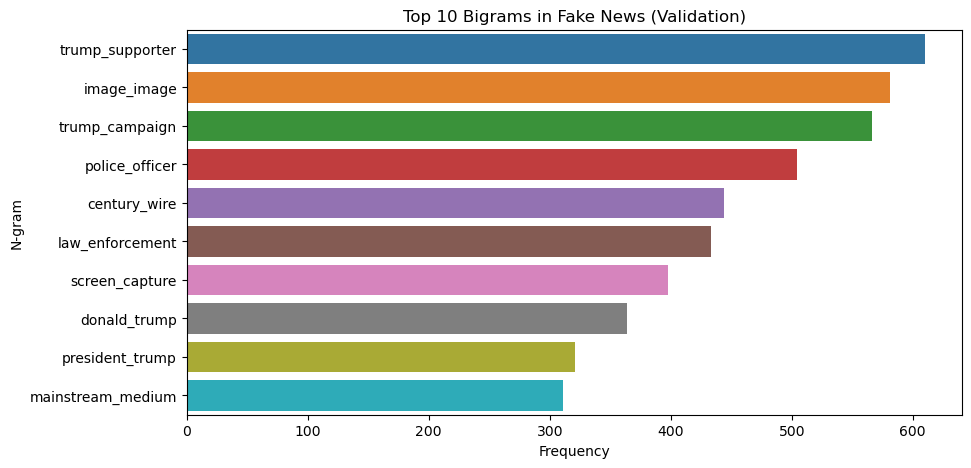


Top 10 Trigrams in True News (Validation): [('reuter_editorial_staff', 81), ('tax_rate_percent', 68), ('respond_request_comment', 62), ('part_reuter_editorial', 58), ('editorial_staff_sap', 58), ('staff_sap_involvement', 58), ('sap_involvement_creation', 58), ('involvement_creation_production', 58), ('official_condition_anonymity', 57), ('article_part_reuter', 51)]


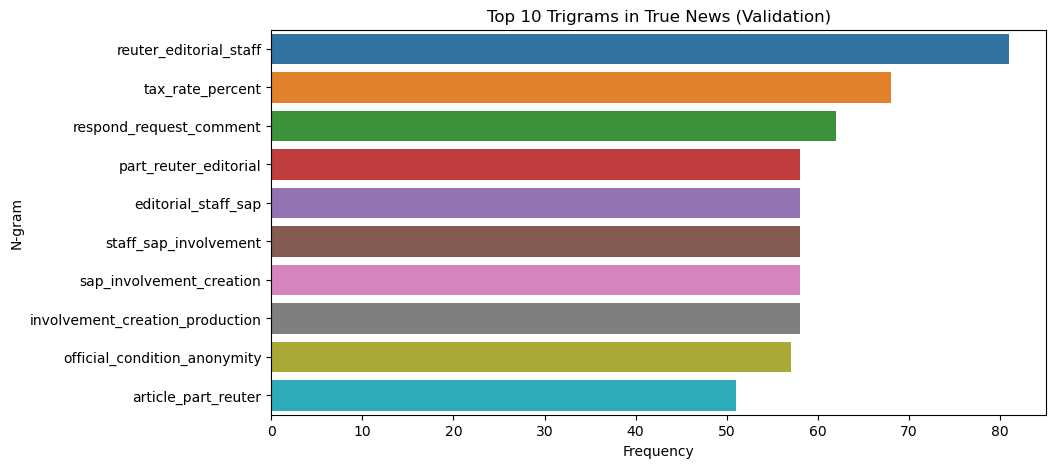


Top 10 Trigrams in Fake News (Validation): [('video_screen_capture', 208), ('image_video_screen', 184), ('news_century_wire', 160), ('image_screen_capture', 142), ('image_getty_image', 130), ('image_chip_image', 76), ('law_enforcement_officer', 72), ('broadcast_boiler_room', 67), ('image_video_screenshot', 67), ('radio_network_broadcast', 60)]


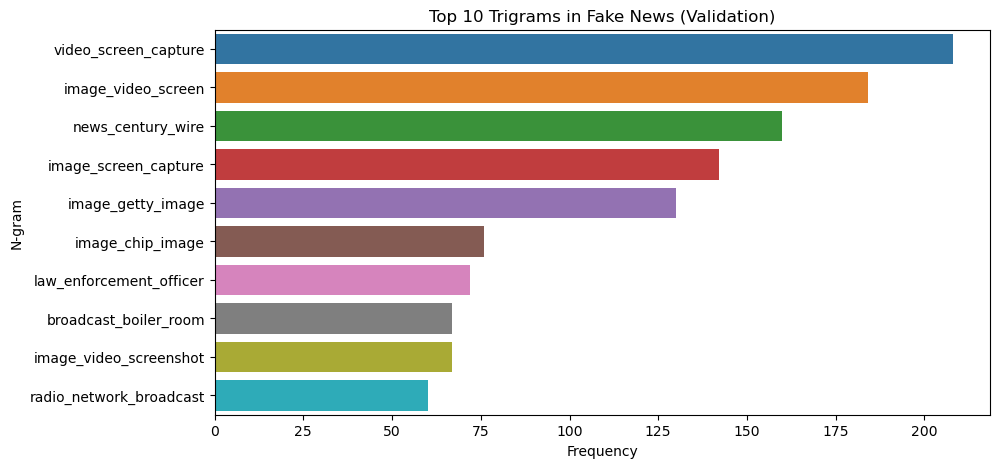

In [24]:
# Optional: EDA on Validation Data
# Validation N-grams (saves val_true_unigrams.png, val_true_bigrams.png, val_true_trigrams.png, etc.)
for n, name in [(1, 'Unigrams'), (2, 'Bigrams'), (3, 'Trigrams')]:
    ngrams = get_top_ngrams(val_df[val_df['news_label'] == 1]['lemmatized_text'], n)
    print(f"\nTop 10 {name} in True News (Validation):", ngrams)
    plot_ngrams(ngrams, f'Top 10 {name} in True News (Validation)', f'val_true_{name.lower()}.png')
    ngrams = get_top_ngrams(val_df[val_df['news_label'] == 0]['lemmatized_text'], n)
    print(f"\nTop 10 {name} in Fake News (Validation):", ngrams)
    plot_ngrams(ngrams, f'Top 10 {name} in Fake News (Validation)', f'val_fake_{name.lower()}.png')

In [25]:
# 6. Feature Extraction
word2vec_model = api.load("word2vec-google-news-300")

def get_word2vec_vectors(texts):
    vectors = []
    for text in tqdm(texts, desc="Extracting Word2Vec vectors"):
        if not text:
            vectors.append(np.zeros(300))
            continue
        words = text.split()
        word_vectors = [word2vec_model[word] for word in words if word in word2vec_model]
        if word_vectors:
            vectors.append(np.mean(word_vectors, axis=0))
        else:
            vectors.append(np.zeros(300))
    return np.array(vectors)

X_train = get_word2vec_vectors(train_df['lemmatized_text'])
X_val = get_word2vec_vectors(val_df['lemmatized_text'])
y_train = train_df['news_label']
y_val = val_df['news_label']

Extracting Word2Vec vectors: 100%|█████████████████████████████████████████████| 13476/13476 [00:02<00:00, 5916.38it/s]


# 7. Model Training and Evaluation

In [26]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_val)
print("\nLogistic Regression Results:")
print("Accuracy:", accuracy_score(y_val, lr_pred))
print("Precision:", precision_score(y_val, lr_pred))
print("Recall:", recall_score(y_val, lr_pred))
print("F1-Score:", f1_score(y_val, lr_pred))
print("\nClassification Report:")
print(classification_report(y_val, lr_pred))


Logistic Regression Results:
Accuracy: 0.8987830216681508
Precision: 0.8890084550345888
Recall: 0.9000778210116731
F1-Score: 0.8945088940448569

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      7051
           1       0.89      0.90      0.89      6425

    accuracy                           0.90     13476
   macro avg       0.90      0.90      0.90     13476
weighted avg       0.90      0.90      0.90     13476



In [27]:
# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_val)
print("\nDecision Tree Results:")
print("Accuracy:", accuracy_score(y_val, dt_pred))
print("Precision:", precision_score(y_val, dt_pred))
print("Recall:", recall_score(y_val, dt_pred))
print("F1-Score:", f1_score(y_val, dt_pred))
print("\nClassification Report:")
print(classification_report(y_val, dt_pred))


Decision Tree Results:
Accuracy: 0.8104036806173939
Precision: 0.819412347309343
Recall: 0.7726070038910506
F1-Score: 0.7953216374269007

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      7051
           1       0.82      0.77      0.80      6425

    accuracy                           0.81     13476
   macro avg       0.81      0.81      0.81     13476
weighted avg       0.81      0.81      0.81     13476



In [28]:
# Random Forest with hyperparameter tuning
rf_param_grid = {'n_estimators': [50, 100], 'max_depth': [None, 10]}
rf_model = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, scoring='f1')
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)
print("\n Random Forest Results (Best Params:", rf_model.best_params_, "):")
print("Accuracy:", accuracy_score(y_val, rf_pred))
print("Precision:", precision_score(y_val, rf_pred))
print("Recall:", recall_score(y_val, rf_pred))
print("F1-Score:", f1_score(y_val, rf_pred))
print("\n Classification Report:")
print(classification_report(y_val, rf_pred))


 Random Forest Results (Best Params: {'max_depth': None, 'n_estimators': 100} ):
Accuracy: 0.9028643514395963
Precision: 0.901443816698054
Recall: 0.8940077821011673
F1-Score: 0.897710400875205

 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      7051
           1       0.90      0.89      0.90      6425

    accuracy                           0.90     13476
   macro avg       0.90      0.90      0.90     13476
weighted avg       0.90      0.90      0.90     13476



The Random Forest model achieves the highest F1-score of 0.898, compared to Logistic Regression (0.895) and Decision Tree (0.795). The F1-score, which balances precision and recall, is critical for this balanced dataset (47.7% true, 52.3% fake). Random Forest also has the highest accuracy (90.29%) and benefits from hyperparameter tuning (n_estimators=100, max_depth=None), making it more effective at distinguishing true and fake news.